# Step-1: Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import glob 
filePaths = glob.glob("/home/prakhar/Desktop/College/3rdYear/SEM-VI/MinorProject/Datasets/archive-2/*.csv")
df_list = [pd.read_csv(file,low_memory=False) for file in filePaths]
df=pd.concat(df_list,ignore_index=True)
print(df.shape)
print(df.head())

(2830743, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6   

In [3]:
df.columns = df.columns.str.strip()
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

# Step-2: Pre-Processing

In [4]:
df.dtypes #Viewing Datatype

Destination Port                 int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
Idle Std                       float64
Idle Max                         int64
Idle Min                         int64
Label                           object
Length: 79, dtype: object

In [5]:
is_inf = df.isin([np.inf, -np.inf])

inf_counts = is_inf.sum()

# Filter to show only columns with infinite values
columns_with_inf = inf_counts[inf_counts > 0]
print("Columns with infinite values:\n", columns_with_inf)

nan_counts = df.isnull().sum()

# Filter to show only columns with NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print("\nColumns with NaN values:\n", columns_with_nan)

combined_counts = nan_counts + inf_counts

# Filter to show only columns with any NaN or inf values
columns_with_nan_or_inf = combined_counts[combined_counts > 0]
print("\nColumns with NaN or infinite values:\n", columns_with_nan_or_inf)

duplicate_rows_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows_count)

Columns with infinite values:
 Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64

Columns with NaN values:
 Flow Bytes/s    1358
dtype: int64

Columns with NaN or infinite values:
 Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64

Number of duplicate rows: 308381


In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True) #Replacing inf values
df.dropna(inplace=True) #Replacing NaN values
df.drop_duplicates(inplace=True) #Removing duplicates to improve accuracy
category_mapping = {
    'BENIGN': 'BENIGN',
    'Bot': 'BOTNET',
    'DDoS': 'DOS',
    'DoS GoldenEye': 'DOS',
    'DoS Hulk': 'DOS',
    'DoS Slowhttptest': 'DOS',
    'DoS slowloris': 'DOS',
    'FTP-Patator': 'BRUTE_FORCE',
    'SSH-Patator': 'BRUTE_FORCE',
    'Heartbleed': 'WEB_ATTACK',
    'Infiltration': 'WEB_ATTACK',
    'PortScan': 'RECONNAISSANCE',
    'Web Attack � Brute Force': 'WEB_ATTACK',
    'Web Attack � Sql Injection': 'WEB_ATTACK',
    'Web Attack � XSS': 'WEB_ATTACK'
}
#Applying Mapping to simplify labels
df['Label'] =df['Label'].map(category_mapping)

In [7]:
print(df['Label'].value_counts())  # Before encoding

Label
BENIGN            2095057
DOS                321759
RECONNAISSANCE      90694
BRUTE_FORCE          9150
WEB_ATTACK           2190
BOTNET               1948
Name: count, dtype: int64


In [8]:
import pandas as pd

# Get class counts
class_counts = df['Label'].value_counts()

# Select classes with more than 5000 samples
selected_classes = class_counts[class_counts > 5000].index.tolist()

"""
# Manually include "WEB_ATTACK" and "BOTNET" if they exist in the dataset
for attack in ["WEB_ATTACK", "BOTNET"]:
    if attack in df['Label'].values and attack not in selected_classes:
        selected_classes.append(attack)
"""
# Select rows where 'Label' is in selected_classes
selected = df[df['Label'].isin(selected_classes)]

dfs = []
for name in selected_classes:
    df_class = selected[selected['Label'] == name]

    # Downsample if the class has more than 5000 samples
    if len(df_class) > 10000:
        df_class = df_class.sample(n=10000, random_state=0)

    dfs.append(df_class)

# Combine all sampled data
balanced_df = pd.concat(dfs, ignore_index=True)

# Check final class distribution
print(balanced_df['Label'].value_counts())

Label
BENIGN            10000
DOS               10000
RECONNAISSANCE    10000
BRUTE_FORCE        9150
Name: count, dtype: int64


In [9]:
balanced_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,62874,4,2,116,186,29,29,29.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,BENIGN
1,57225,86,1,1,0,0,0,0,0.000,0.000000,...,32,0.00000,0.00000,0,0,0.000,0.00000,0,0,BENIGN
2,80,116003861,16,14,440,412,356,0,27.500,87.612784,...,20,46441.09091,31255.09835,140678,36852,9995557.727,14892.00092,10000000,9950679,BENIGN
3,443,5683083,8,6,397,3716,216,0,49.625,79.224703,...,20,269399.00000,0.00000,269399,269399,5413681.000,0.00000,5413681,5413681,BENIGN
4,53,23652,1,1,48,128,48,48,48.000,0.000000,...,20,0.00000,0.00000,0,0,0.000,0.00000,0,0,BENIGN


In [10]:
from imblearn.over_sampling import SMOTE

x = balanced_df.drop('Label', axis=1)
y = balanced_df['Label']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(x, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Label'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

print(blnc_data['Label'].value_counts())
blnc_data.head()

Label
DOS               10000
RECONNAISSANCE    10000
BRUTE_FORCE       10000
BENIGN            10000
Name: count, dtype: int64


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
18345,80,437271,3,6,26,11601,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DOS
11365,80,63141874,7,0,0,0,0,0,0.000000,0.000000,...,40,7014508.0,0.0,7014508,7014508,18700000.0,12200000.0,32100000,8015922,DOS
13221,80,144373,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DOS
19432,80,99055865,6,6,315,11595,303,0,52.500000,122.754633,...,20,16989.0,0.0,16989,16989,97900000.0,0.0,97900000,97900000,DOS
23556,9091,54,1,1,2,6,2,2,2.000000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,RECONNAISSANCE


In [11]:
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
x = blnc_data.drop('Label',axis=1)
y = blnc_data['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
n_components = 20
ipca = IncrementalPCA(n_components=n_components, batch_size=500)
x_pca = ipca.fit_transform(X_scaled) 
print(f"Explained Variance Ratio: {sum(ipca.explained_variance_ratio_):.4f}")
x = x_pca

Explained Variance Ratio: 0.9405


In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,shuffle=True)

# Step-3: Applying Classifier Algorithms

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

#### Step-3.1: Applying Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier #Importing Random Forest classifier
rf = RandomForestClassifier(n_estimators=1,max_depth=7,random_state=42)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test) #Performing Random Forest

In [60]:
print(classification_report(y_test, y_pred)) #Printing Classification Report
class_indices = rf.classes_
print(class_indices)

                precision    recall  f1-score   support

        BENIGN       0.94      0.93      0.93      2457
   BRUTE_FORCE       0.99      0.96      0.98      2560
           DOS       0.95      0.97      0.96      2510
RECONNAISSANCE       0.98      0.99      0.98      2473

      accuracy                           0.96     10000
     macro avg       0.96      0.96      0.96     10000
  weighted avg       0.96      0.96      0.96     10000

['BENIGN' 'BRUTE_FORCE' 'DOS' 'RECONNAISSANCE']


In [61]:
cv_rf = cross_val_score(rf, x_train, y_train, cv=5)
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf)))
print(f'\nMean cross-validation score: {cv_rf.mean():.2f}')


Cross-validation scores: 0.9615, 0.967, 0.9751666666666666, 0.9733333333333334, 0.9715

Mean cross-validation score: 0.97


In [62]:
print(rf.score(x_train,y_train)) #RF Score x_train,y_train

0.9668666666666667


In [63]:
print(rf.score(x_test, y_test)) #RF Score x_test,y_test

0.9647


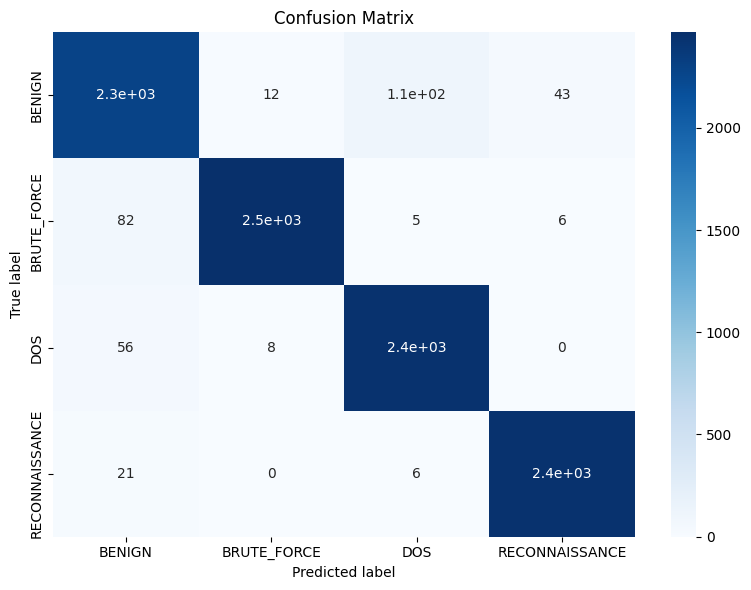

In [64]:
# Compute ROC curve
# False Positive Rate, True Positive Rate
conf_mtr = confusion_matrix(y_true=y_test,y_pred=y_pred)
# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

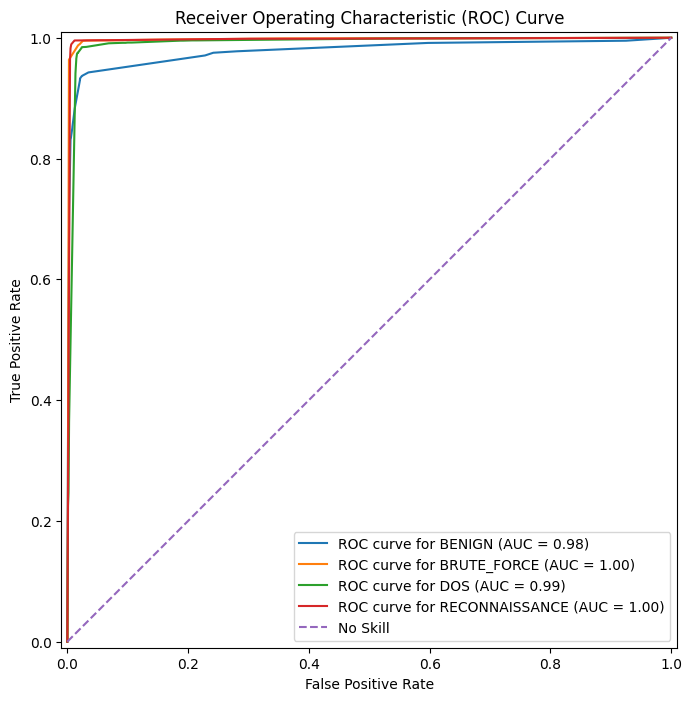

In [65]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    y_score = rf.predict_proba(x_test)[:, i]
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score,
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Step-3.2: Applying KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier #Importing KNN
knn = KNeighborsClassifier(n_neighbors= 100) #Changing Value Manually (Due to Performance Reasons)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)  # Performing Random Forest

In [77]:
print(classification_report(y_test, y_pred)) #Printing Classification Report

                precision    recall  f1-score   support

        BENIGN       0.96      0.85      0.90      2457
   BRUTE_FORCE       0.93      1.00      0.96      2560
           DOS       0.94      0.96      0.95      2510
RECONNAISSANCE       0.97      0.99      0.98      2473

      accuracy                           0.95     10000
     macro avg       0.95      0.95      0.95     10000
  weighted avg       0.95      0.95      0.95     10000



In [78]:
cv_knn = cross_val_score(knn, x_train, y_train, cv=5)
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn)))
print(f'\nMean cross-validation score: {cv_knn.mean():.2f}')


Cross-validation scores: 0.9448333333333333, 0.9426666666666667, 0.9456666666666667, 0.9488333333333333, 0.946

Mean cross-validation score: 0.95


In [79]:
print(knn.score(x_train, y_train)) #RF Score x_train,y_train

0.9475666666666667


In [80]:
print(knn.score(x_test, y_test)) #RF Score x_train,y_train

0.9492


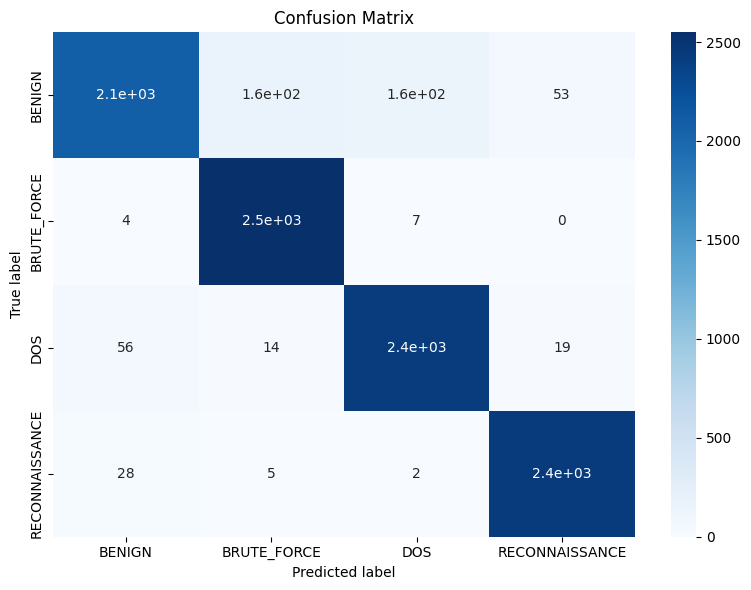

In [81]:
# Compute Confusion Matrix
# False Positive Rate, True Positive Rate
conf_mtr = confusion_matrix(y_true=y_test, y_pred=y_pred)
# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mtr, annot=True, cmap='Blues',
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

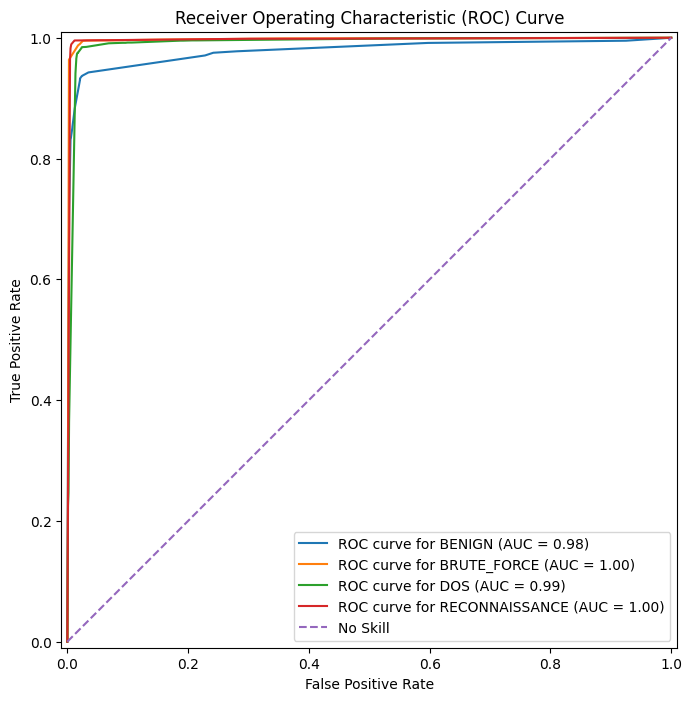

In [82]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(lb.classes_):
    y_score = rf.predict_proba(x_test)[:, i]
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_score,
        name=f'ROC curve for {class_name}',
        ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Step-3.3: Applying LSTM

In [ ]:
from tensorflow import keras #Importing For LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import InputLayer

In [ ]:
time_step = 1
features = 78
model = Sequential()
model.add(InputLayer(shape=(time_step, features)))
model.add(LSTM(64, return_sequences=True))  # Keep sequence output
model.add(LSTM(64))  # Now this LSTM gets 3D input
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

In [ ]:
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = np.array(x_train)  # Convert DataFrame to NumPy array
X_test = np.array(x_test)

print("X_train shape before reshaping:", X_train.shape)
print("X_test shape before reshaping:", X_test.shape)


# (samples, timesteps, 1 feature)
X_train = X_train.reshape(X_train.shape[0], 78, 1)
X_test = X_test.reshape(X_test.shape[0], 78, 1)


history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test)) #Training the model
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Convert back to original scale
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
print(classification_report(y_test,y_pred))